Нужно было использовать глубокий классификатор, заюзали ResNet, потому что эти residual connections позволяют глубокие сети обучать и проблему затухающих градиентов решать. 

Из-за величины размеров кадров, схожей структуры в разных местах среза и малого количества обучающих примеров решили нарезать. Для этого выбрали полностью сверточную сеть. Из-за того, что размер изображения стал маленький посмотрели в сторону соревнования CIFAR по классификации, там как раз снимки небольшого размера. На этом соревновании круто выступила модификация ResNet – Wide ResNet.  Там суть в том, что вместо углубления сети по количеству слоев её расширяют по количеству параметров при малом количестве слоев. Выбрали легкую сетку cifar wide renset 16. 16 значит, что у неё 16 слоев от натурально ResNet. К примеру чаще всего юзают обычный resnet 100. А у этой всего 16 слоев, но есть параметр k, который значит, во сколько раз у широкой сети больше параметров, чем у обычной ResNet. Официальная версия этой сети cifar_wiide_resnet_16_10. Мы её модифицировали с параметром 2. При этом уменьшение параметра ускорило модель и снизила вес параметро с 68 МБ до 2 МБ. Это было сделано, потому что у нас нет железа для обучения глубокой сети, а результаты у сеток вполне сходные, если датасет нормальный. А еще в задании указано, что мы должны сеть под задачу заточить. (но эту модификацию я просто один раз сделал и постоянно на работе юзаю). Еще для удобства встраивания докрутили Softmax выход у сети. Этого слоя не было в mxnet, пришлось дописать. Так что сетка сразу возвращает четкий выход в вероятностях (почти).

В рамках данного исследования эксперименты проводились на множестве изображений микросрезов образцов гелей содержащих различные добавки и полученных при разных температурных режимах. Каждый класс в данных множествах сформирован на основании использованных добавок(или без них) и температурного режима обработки.


In [1]:
# %load report.py
from matplotlib import pyplot as plt, axes
import os
import numpy as np
import csv 

def clear():
    plt.clf()
    plt.cla()
    plt.close()

dict_path = os.path.join(os.getcwd(), "res/lot-of-pics/gel_cls.003_classes.txt")
test = np.genfromtxt("testing/test_error_matrix.csv", delimiter=',')
val = np.genfromtxt("testing/val_error_matrix.csv", delimiter=',')
with open(dict_path) as f:
    content = f.readlines()
class_names = [x.strip() for x in content]

def heatmap(data):
    plt.xticks(np.arange(20), class_names)
    plt.yticks(np.arange(20), class_names)
    plt.xticks(rotation=90)
    plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.show()
    clear()

def metrics(dataset_name, description = ""):
    data = np.empty((0, 3))
    with open(dataset_name, 'r') as csvfile:
        i = 0
        reader = csv.reader(csvfile, delimiter=' ')
        for train_error, val_error in reader:
            if train_error == "train-error":
                continue
            train_error = float(train_error)
            val_error = float(val_error)

        #                   [index, train_error, val_error]
            i += 1
            data = np.append(data, np.array([[i, train_error, val_error]]), axis=0)
    plt.title("Метрики обучения: " + description)
    plt.xticks(rotation=90)
    plt.plot( data[:,1], label='Train error')
    plt.plot( data[:,2], label='Validation error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    clear()

def errorsTest():
    plt.title("Матрица ошибок на тестовых данных")
    heatmap(test)

def errorsTestVal():
    plt.title("Матрица ошибок на тестовых и валидационных данных")
    heatmap(test + val)

def errors():
    prefixes = ["test", "val"]
    suffixes = ["fn", "fp", "tp"]
    for prefix in prefixes: 
        for suffix in suffixes:
            print(prefix + "(" + suffix + "): ")
            filename = os.path.join(os.getcwd(), "testing", prefix + "_" + suffix + ".csv")
            metric = np.genfromtxt(filename, delimiter=',')
            plt.title("Ошибки: " + prefix + " " + suffix)
            plt.bar(x=class_names, height=metric, label=class_names)
            plt.xticks(rotation=90)
            plt.show()
            print(metric)


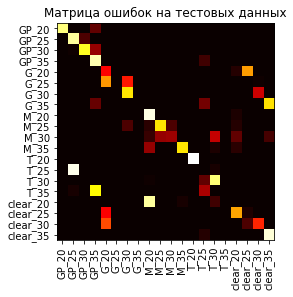

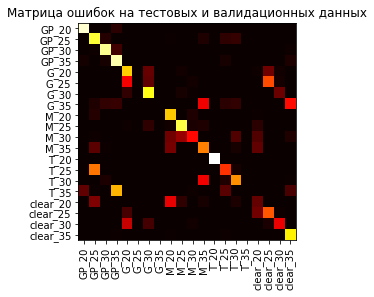

test(fn): 


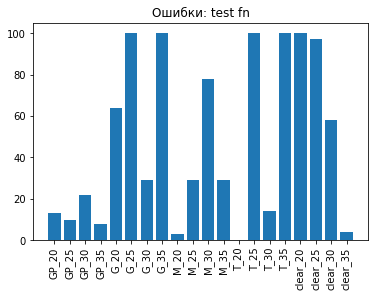

[ 13.  10.  22.   8.  64. 100.  29. 100.   3.  29.  78.  29.   0. 100.
  14. 100. 100.  97.  58.   4.]
test(fp): 


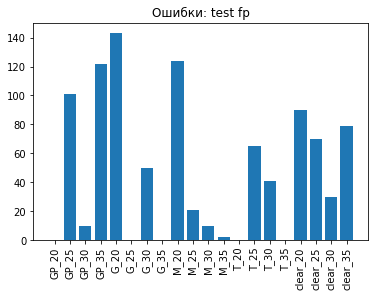

[  0. 101.  10. 122. 143.   0.  50.   0. 124.  21.  10.   2.   0.  65.
  41.   0.  90.  70.  30.  79.]
test(tp): 


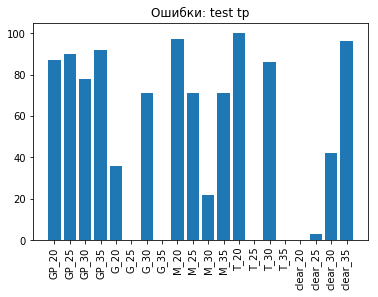

[ 87.  90.  78.  92.  36.   0.  71.   0.  97.  71.  22.  71. 100.   0.
  86.   0.   0.   3.  42.  96.]
val(fn): 


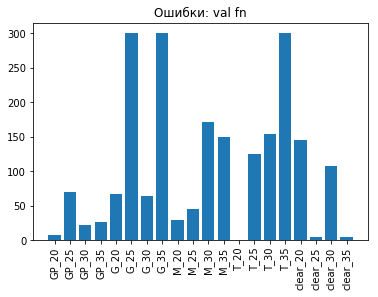

[  7.  70.  22.  26.  67. 300.  64. 300.  30.  45. 172. 149.   0. 125.
 154. 300. 146.   5. 107.   5.]
val(fp): 


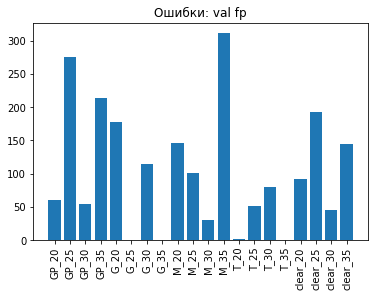

[ 61. 276.  54. 214. 178.   0. 115.   0. 146. 101.  31. 311.   2.  52.
  80.   0.  92. 192.  45. 144.]
val(tp): 


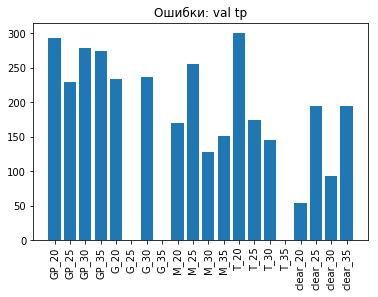

[293. 230. 278. 274. 233.   0. 236.   0. 170. 255. 128. 151. 300. 175.
 146.   0.  54. 195.  93. 195.]


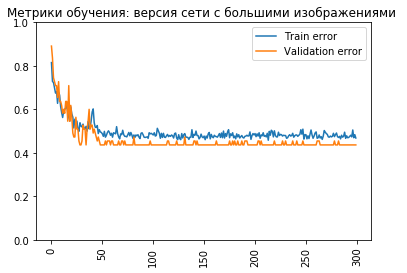

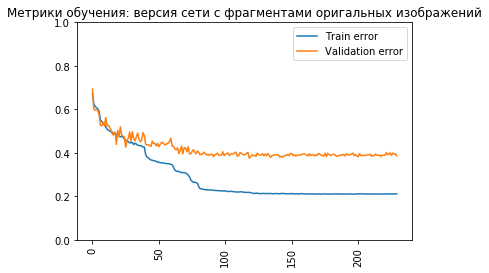

In [2]:
errorsTest()
errorsTestVal()
errors()

metrics("res/big-pics/metrics.txt", "версия сети с большими изображениями ")
metrics("res/lot-of-pics/metrics.txt", "версия сети с фрагментами оригальных изображений")

In [8]:
# %load cnn/viz_model.py
import argparse
import os
import mxnet as mx

def showModel(params_dir, net_name):
    ctx = [mx.cpu()]
    sym_path = os.path.join(params_dir, '{}-symbol.json'.format(net_name))
    net = mx.symbol.load(sym_path)

    mx.viz.print_summary(symbol=net)

In [9]:
print("Модель для работы с большими картинками")
showModel("res/big-pics", "gel_cls.002")

Модель для работы с большими картинками
________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
cifarwideresnet0_batchnorm0_fwd(BatchNorm)                                  0           data                            
________________________________________________________________________________________________________________________
cifarwideresnet0_conv0_fwd(Convolution)                                     0           cifarwideresnet0_batchnorm0_fwd 
_________________________________________________________________________________________________________________